# Data Exploration

The `src.crypto_api` module contains useful functions for working with *CoinGecko* API. The available functions are:
 
`create_prices_dataframe(symbols, interval, range_period, sleep_time: int)` - Fetches and combines cryptocurrency prices for specified symbols with a specified time interval and sleep time between requests.
- *Parameters*:
   - `symbols` (list): List of cryptocurrency symbols or IDs (e.g., ["bitcoin", "ethereum"]).
   - `interval` (str): The time interval for the data (e.g., 'daily').
   - `range_period` (int): The number of days for the specified time interval.
   - `sleep_time` (int): The sleep time in seconds between API requests.
- *Returns*:
   - pd.DataFrame: Combined DataFrame with prices for all specified cryptocurrencies.

`get_supported_coins()` - Fetches the list of supported cryptocurrency names or symbols from the CoinGecko API.
-  *Returns*:
   - list: List of supported cryptocurrency names or symbols.

In [771]:
from src import crypto_api

## Data Extraction

To begin our analysis, we first explore the cryptocurrencies supported by the CoinGecko API:

In [772]:
supported_coins = crypto_api.get_supported_coins()
len(supported_coins)

12428

Next, we store the names of these supported cryptocurrencies in a text file, *supported_coins.txt*, to facilitate readability:

In [773]:
with open("supported_coins.txt", 'w') as file:
    for coin in supported_coins:
        file.write(f"{coin}\n")

We are going to analyze five prominent cryptocurrencies: Bitcoin, Ethereum, Solana, Dogecoin, and Binance Coin. To gather historical daily price data, we have retrieve information spanning 14 years until the current date:

In [774]:
symbols = ["bitcoin", "ethereum", "solana", "dogecoin", "binancecoin"]
interval = "daily"
range_period = 365 * 14 # 14 years
df = crypto_api.create_prices_dataframe(symbols, interval, range_period, sleep_time=10)
df.head()

,bitcoin_price,ethereum_price,solana_price,dogecoin_price,binancecoin_price
timestamp,,,,,
2013-04-28,135.30,NaN,NaN,NaN,NaN
2013-04-29,141.96,NaN,NaN,NaN,NaN
2013-04-30,135.30,NaN,NaN,NaN,NaN
2013-05-01,117.00,NaN,NaN,NaN,NaN
2013-05-02,103.43,NaN,NaN,NaN,NaN


Upon retrieving the data, an initial examination reveals the presence of a considerable number of `NaN` values. This observation is expected, considering that many cryptocurrencies, except for the pioneering Bitcoin, have emerged relatively recently.

In [775]:
df.isna().sum()

bitcoin_price          12
ethereum_price        842
solana_price         2550
dogecoin_price        244
binancecoin_price    1614
dtype: int64

## Data Visualization

The following function `plot_prices()` let us plot the cryptocurrency's prices of our dataframe: 


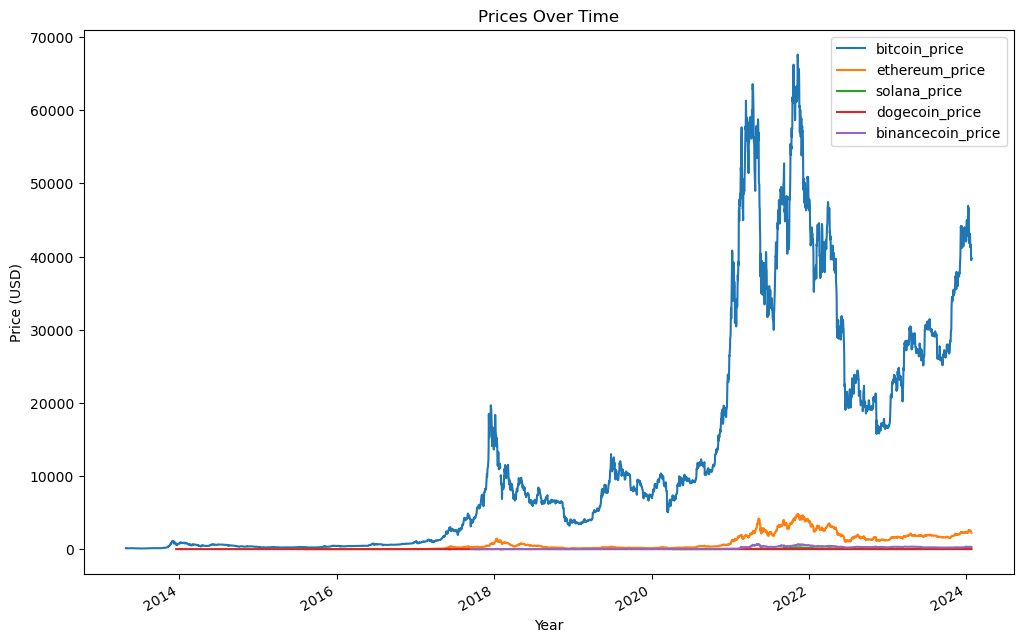

In [776]:
import matplotlib.pyplot as plt

def plot_prices(df, **kwargs):
    """Plots cryptocurrency prices over time."""
    df.plot(title="Prices Over Time", figsize=(12, 8), **kwargs)
    plt.xlabel("Year")
    plt.ylabel("Price (USD)")
    plt.show()

plot_prices(df)

We can get more insights with the `df.describe()` method:

In [777]:
df.describe()

,bitcoin_price,ethereum_price,solana_price,dogecoin_price,binancecoin_price
count,3923.000000,3093.000000,1385.000000,3691.000000,2321.000000
mean,12940.920618,936.180059,46.117307,0.039135,164.091019
std,15979.122424,1094.331760,53.957103,0.076847,173.596232
min,67.809000,0.432979,0.513923,0.000087,0.039818
25%,582.944500,134.316029,13.252557,0.000270,15.069978
50%,6690.832152,345.912568,24.983306,0.002583,32.690952
75%,20668.841423,1660.679110,53.648728,0.062361,301.473899
max,67617.015545,4815.004634,259.239558,0.681842,675.098974


As there is a considerable difference in the price of the cryptocurrency, it is hard to distinguish their behaviour. To solve this, we use *Min-Max Normalization* to normalize the dataframe so each cryptocurrency $c_j$ has prices $p^j = \{p_i \in [0, 1] \mid i = 0, 1, \dots, n\}$ such that $p^j_i$ is the price of $c_j$ at time $i$.

$$
p^{j\prime}_i = \frac{p^j_i - \min(p^j)}{\max(p^j) - \min(p^j)}
$$

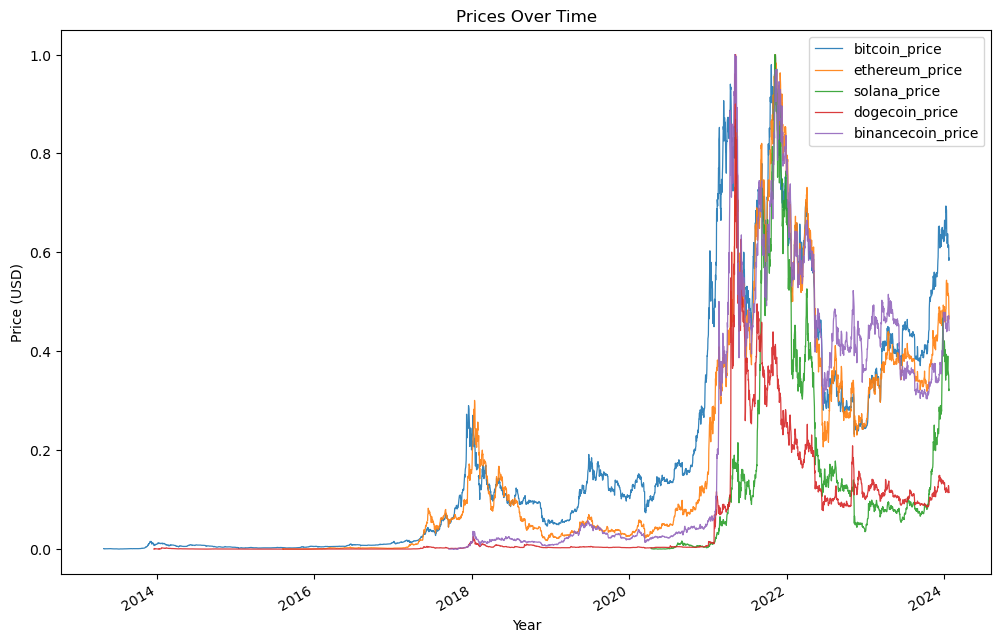

In [778]:
normalized_df = df.copy()
for crypto in df.columns:
    max_price = df[crypto].max()
    min_price = df[crypto].min()
    normalized_df[crypto] = normalized_df[crypto] - min_price
    normalized_df[crypto] /= max_price - min_price
plot_prices(normalized_df, linewidth=0.9, alpha=0.9)

For a detailed analysis of the normalized price behavior of cryptocurrencies, we can narrow our focus to the time frame from January 1, 2023, to January 1, 2024. This period allows us to closely examine the market dynamics and trends that shaped the cryptocurrency landscape over the past year.

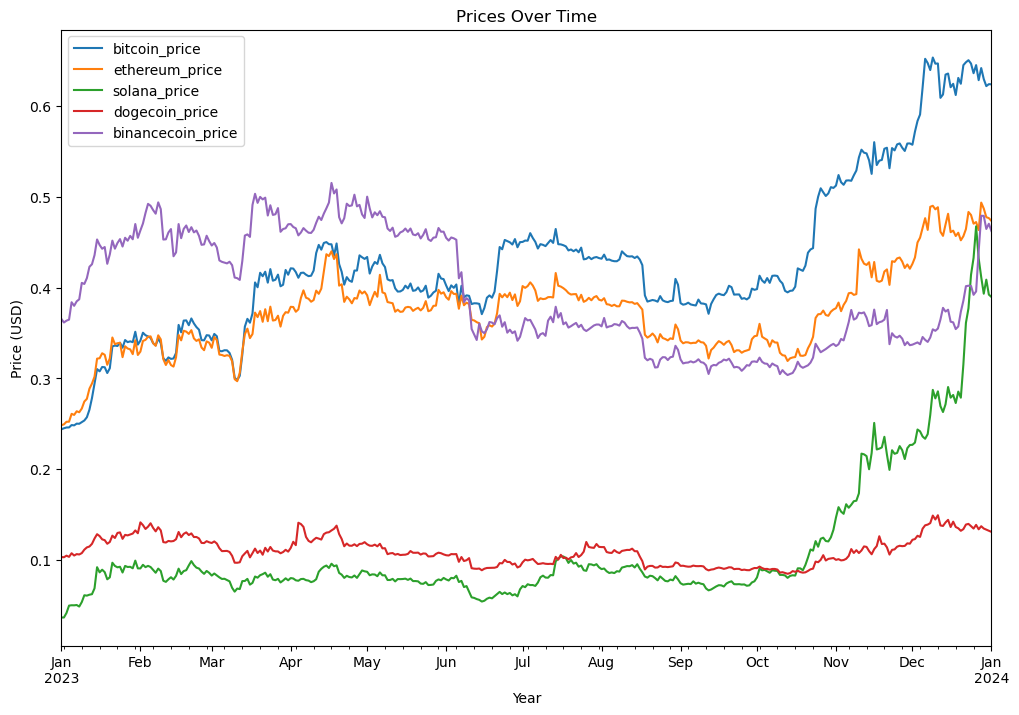

In [779]:
start_date = '2023-01-01'
end_date = '2024-01-01'
plot_prices(normalized_df[start_date:end_date])

There is an observable shared pattern in the behavior of cryptocurrencies price. This becomes explicit when we analyze the Pearson correlation coefficient:

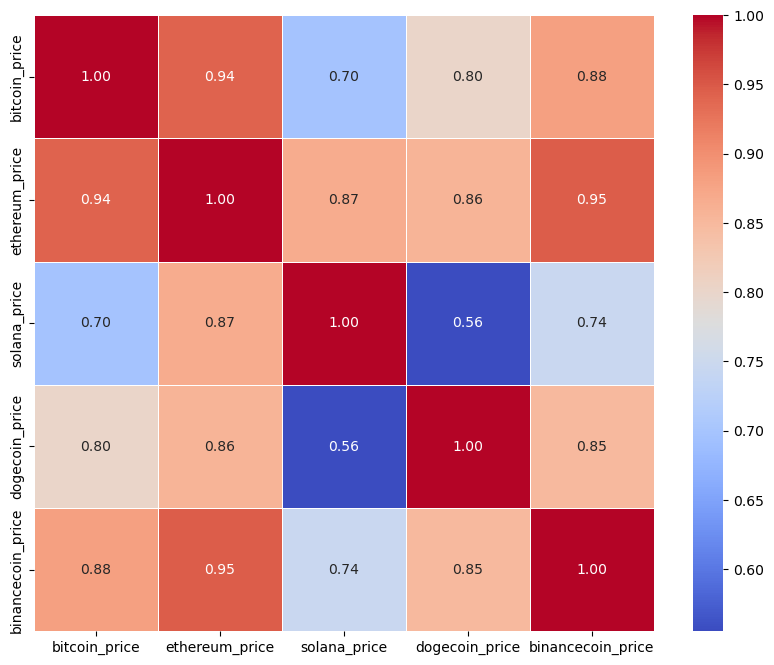

In [780]:
import seaborn as sns


plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.show()

> The normalized dataframe preserves the data correlation.

# Cryptocurrency Price Forecasting

## Problem Formulation

We have the historical data of the cryptocurrencies in the form of prices of cryptocurrency accounted on a daily basis [[1]](#references). Let the cryptocurrency prices at the individual timestamps be $\{p_0, p_1, p_2, p_3, \dots, p_n\}$, where $p_i$ denotes price at time stamp $i$. Let the input 
window length be $w$, the input vector be $v$, and the output be $o$, then $v$ and $o$ can be denoted as:

$$
v = [p_{i-w}, p_{i-w+1}, p_{i-w+2}, \dots, p_{i-1}]
$$

$$
o = [p_{i}]
$$

The aim is to predict the $p_{i}$ value using the input vector $v$ containing the past values.

## Data Preparation

We want to format the dataframe for training an LSTM neural network by including past cryptocurrency prices as features.

In [781]:
import pandas as pd


def prepare_dataframe_for_lstm(df, symbol, input_window):
    df = df.rename(columns={f"{symbol}_price": "p(i)"})
    df = df[["p(i)"]]
    columns_to_concat = [df["p(i)"].shift(i).rename(f"p(i-{i})") for i in range(1, input_window + 1)]
    df = pd.concat([df] + columns_to_concat, axis=1).dropna()

    return df

We choose the Bitcoin cryptocurrency and an input window $w=10$. Our input vector $v$ is composed by the columns $p(i-1), p(i-2), \dots, p(i-10)$, and the output value we want to predict is the column $p(i)$.

In [782]:
btc_prices = prepare_dataframe_for_lstm(df, symbol="bitcoin", input_window=10)
btc_prices.head()

,p(i),p(i-1),p(i-2),p(i-3),p(i-4),p(i-5),p(i-6),p(i-7),p(i-8),p(i-9),p(i-10)
timestamp,,,,,,,,,,,
2013-05-08,112.640,106.40,118.33,116.79,111.25,91.01,103.43,117.00,135.30,141.96,135.30
2013-05-09,113.000,112.64,106.40,118.33,116.79,111.25,91.01,103.43,117.00,135.30,141.96
2013-05-10,118.780,113.00,112.64,106.40,118.33,116.79,111.25,91.01,103.43,117.00,135.30
2013-05-11,113.010,118.78,113.00,112.64,106.40,118.33,116.79,111.25,91.01,103.43,117.00
2013-05-12,114.713,113.01,118.78,113.00,112.64,106.40,118.33,116.79,111.25,91.01,103.43


Normalization helps in improving the convergence of the training process and can prevent exploding or vanishing gradients. Therefore, we will use the normalized dataframe and convert it to numpy array to get our training and testing data.

In [783]:
data = prepare_dataframe_for_lstm(normalized_df, symbol="bitcoin", input_window=10).to_numpy()
data

array([[6.63679150e-04, 5.71302047e-04, 7.47914041e-04, ...,
        9.99138309e-04, 1.09773310e-03, 9.99138309e-04],
       [6.69008598e-04, 6.63679150e-04, 5.71302047e-04, ...,
        7.28224690e-04, 9.99138309e-04, 1.09773310e-03],
       [7.54575851e-04, 6.69008598e-04, 6.63679150e-04, ...,
        5.27334099e-04, 7.28224690e-04, 9.99138309e-04],
       ...,
       [5.83825082e-01, 6.13983385e-01, 6.15229997e-01, ...,
        6.17818120e-01, 6.33325952e-01, 6.33998870e-01],
       [5.88691520e-01, 5.83825082e-01, 6.13983385e-01, ...,
        6.29460052e-01, 6.17818120e-01, 6.33325952e-01],
       [5.88301445e-01, 5.88691520e-01, 5.83825082e-01, ...,
        6.37760158e-01, 6.29460052e-01, 6.17818120e-01]])

The first column of the array is the label vector $y$, and the other columns are the feature matrix $X$. We also flip $X$ columns so that the first column is $p(i-10)$, the second columns is $p(i-9)$, etc.

In [784]:
import numpy as np

X = np.flip(data[:, 1:], axis=1)
y = data[:, 0]

X.shape, y.shape

((3881, 10), (3881,))

To work with PyTorch LSTM, it is necessary to introduce an additional dimension to the input data. This ensures that the data conforms to the required shape of `(sequence_length, batch_size, input_size)` [[2]](#references).

In [785]:
X = X.reshape((*X.shape, 1))
y = y.reshape((*y.shape, 1))

X.shape, y.shape

((3881, 10, 1), (3881, 1))

We split the data into two sets: the training set, comprising the first 95%, and the testing set, consisting of the remaining 5%:

In [786]:
split_index = int(len(X) * 0.95)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

And convert the arrays to Convert to PyTorch tensors:

In [787]:
import torch

X_train_tensor = torch.from_numpy(X_train.copy()).float()
X_test_tensor = torch.from_numpy(X_test.copy()).float()
y_train_tensor = torch.from_numpy(y_train.copy()).float()
y_test_tensor = torch.from_numpy(y_test.copy()).float()

Code for processing data samples can get messy and hard to maintain [[3]](#references). PyTorch provides two data primitives: `torch.utils.data.DataLoader` and `torch.utils.data.Dataset` to handle this issue. Let's create a dataset class to store the train and test data: 

In [788]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, i: int):
        return self.X[i], self.y[i]
    
    
train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
test_dataset = TimeSeriesDataset(X_test_tensor, y_test_tensor)

We use PyTorch's `DataLoader` to create efficient data loaders for both training and testing datasets. These loaders enable us to iterate over batches of data, a crucial step during the training and evaluation of our PyTorch model. By specifying a batch size (16 in this case), the data is processed in manageable chunks, enhancing computational efficiency. Additionally, shuffling the training data (`shuffle=True`) helps prevent the model from overfitting to the order of the data, ensuring a more robust training process.

In [789]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

We can confirm that the data loader effectively divides the dataset into batches, each containing precisely 16 samples. To illustrate, we extract the first batch from the training loader:

In [790]:
first_X_batch, first_y_batch = list(train_loader)[0]
first_X_batch.shape, first_y_batch.shape

(torch.Size([16, 10, 1]), torch.Size([16, 1]))

## LSTM Implementation

The following set of equations defines the computations within an LSTM cell, capturing the dynamics of the input gate, forget gate, cell gate, output gate, hidden state, and cell state:

$$
i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi})\\
f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf})\\
g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg})\\
o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho})\\
c_t = f_t \odot c_{(t-1)} + i_t \odot g_t\\
h_t = o_t \odot \tanh(c_t)
$$


Where:

* **Input Gate ($i_t$):** The input gate controls the flow of information that should be stored in the cell state. It determines which parts of the input and the previous hidden state should be updated.

* **Forget Gate ($f_t$):** The forget gate decides which information from the cell state should be discarded or forgotten. It considers the previous cell state and the current input to determine what information is no longer relevant.

* **Cell Gate ($g_t$):** The cell gate calculates the new candidate values that could be added to the cell state. It uses the input and the previous hidden state to propose new information that could be added to the cell state.

* **Output Gate ($o_t$):** The output gate decides what the next hidden state should be based on the input, the previous hidden state, and the updated cell state. It regulates the information flow from the cell state to the hidden state.

The corresponding PyTorch implementation of an LSTM module is provided below:

In [826]:
import torch.nn as nn


class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, device: str):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
        self.device = device
        self.to(device)

    def forward(self, x: torch.Tensor):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

The `LSTM` class has four parameters:

* `input_size` – The number of expected features in the input $x$.
* `hidden_size` – The number of features in the hidden state $h$.
* `num_layers` – Number of recurrent layers. 
* `device` - Device index to select.

> The nn.Linear(hidden_size, 1) layer serves as a fully connected linear layer responsible for mapping the LSTM output of the last time step to a single scalar value. This scalar value represents the final prediction or output of the LSTM network.

We can now set up the device for computation, preferring GPU if available, and then create an LSTM neural network with:

* `input_size=1` - There is only one input: the Bitcoin price vector $x = [p_{i-w}, p_{i-w+1}, p_{i-1}]$.
* `hidden_size=4` - The choice of this parameter depends on the complexity of the patterns we want the network to learn.
* `num_layers=1`: No stacks, only one layer.

> The hidden size is often a hyperparameter that needs to be tuned based on the specific characteristics of your data and the task at hand. A common practice is to start with a small value (e.g., 4 or 8) and gradually increase it if the model performance does not meet expectations.

In [792]:
device  = "cuda:0" if torch.cuda.is_available() else "cpu"
model = LSTM(input_size=1, hidden_size=4, num_layers=1, device=device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

Below are the `train_epoch()` and `validate_epoch()` functions, designed to train and validate the LSTM model for one epoch using a specified dataset.

In [793]:
from torch.nn import MSELoss
from torch.optim import Adam


def train_epoch(
        model: LSTM, 
        train_loader: DataLoader, 
        loss_function: MSELoss, 
        optimizer: Adam,
        verbose: bool,
    ) -> LSTM:
    model.train(mode=True) # Sets model to training mode
    cumulative_loss = 0

    for batch in train_loader:
        x_batch = batch[0].to(device)
        y_batch = batch[1].to(device)
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        cumulative_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = cumulative_loss / len(train_loader)

    if verbose:
        print(f"-- Training loss: {avg_loss}")

    return avg_loss

def validate_epoch(
        model: LSTM, 
        test_loader: DataLoader, 
        loss_function: MSELoss, 
        verbose: bool,
    ) -> LSTM:
    model.train(False) # Sets model to evaluation mode
    cumulative_loss = 0

    for batch in test_loader:
        x_batch = batch[0].to(device)
        y_batch = batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            cumulative_loss = loss.item()
        
    avg_loss = cumulative_loss/len(test_loader)

    if verbose:
        print(f"-- Validation loss: {avg_loss}")
    
    return avg_loss

The `run_model()` function executes for `num_epochs` epochs, utilizing the provided LSTM model, training data loader, loss function, and optimizer. During each epoch, it calculates the average training loss and validation loss. The results are then organized into a Pandas DataFrame for further analysis. The optional `verbose` parameter allows for detailed progress printing. The function returns the DataFrame with columns for training and validation losses indexed by epoch.

In [794]:
import pandas as pd

def run_model(
        num_epochs: int,
        model: LSTM, 
        train_loader: DataLoader, 
        test_loader: DataLoader,
        loss_function: MSELoss, 
        optimizer: Adam,
        verbose: bool,
    ) -> LSTM:
    train_loss_list, validation_loss_list = [], []
    for epoch in range(0, num_epochs):
        if verbose:
            print(f"\n\nEpoch {epoch}:")
        train_loss = train_epoch(model, train_loader, loss_function, optimizer, verbose)
        validation_loss = validate_epoch(model, test_loader, loss_function, verbose)
        train_loss_list.append(train_loss)
        validation_loss_list.append(validation_loss)
    
    df = pd.DataFrame(
        {"train_loss":train_loss_list, "validation_loss":validation_loss_list}
        )
    df.index.name = "epoch"
    return df

We will train the LSTM model for 100 epochs using a learning rate of 0.001. During each epoch, the model's parameters will be updated based on the Mean Squared Error (MSE) loss calculated between the predicted and actual values. This iterative process aims to optimize the model's performance on the training data. Subsequently, we will assess the model's generalization to unseen data by validating its performance on the test dataset after each epoch. The learning rate of 0.001 influences the step size in the optimization process, affecting the convergence and stability of the training. Adjustments to the learning rate can significantly impact the training dynamics and final model accuracy.


In [795]:
learning_rate = 0.001
num_epochs = 100
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)
loss_df = run_model(
    num_epochs, model, 
    train_loader, test_loader, 
    loss_function, optimizer, 
    verbose=False)

loss_df.head()

,train_loss,validation_loss
epoch,,
0,0.067730,0.012739
1,0.045344,0.008267
2,0.014374,0.000022
3,0.001527,0.000255
4,0.001087,0.000289


We can plot the losses and see how its decreases as the number of epochs increases:

<Axes: xlabel='epoch', ylabel='MSE Loss'>

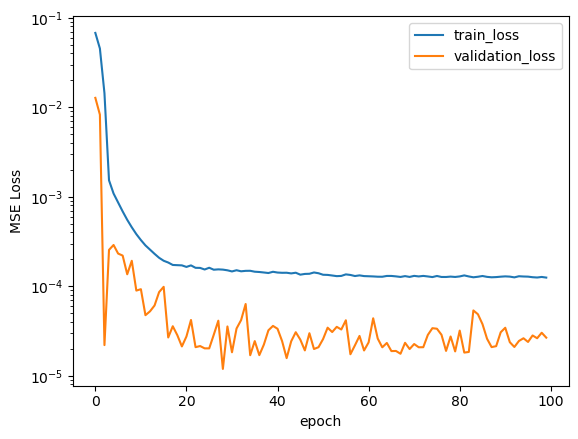

In [796]:
loss_df.plot(ylabel="MSE Loss", logy=True)

## Model Performance


Now that our LSTM model is trained for BTC price forecasting, let's delve into its performance on both the training and test sets. In this section we will analyze visualizations, such as actual vs. predicted price plots and residual analysis, to comprehensively understand the regression performance of our trained LSTM model.

First, we start by making predictions on the train and test set:

In [797]:
with torch.no_grad():
    train_predictions = model(X_train_tensor.to(device)).to("cpu").numpy()
    test_predictions = model(X_test_tensor.to(device)).to("cpu").numpy()

> The `torch.no_grad()` context ensures that no gradients are calculated during the prediction phase, as we are not performing any further training.

Once we make our predictions, we can visualize the actual vs. predicted price of the train set:

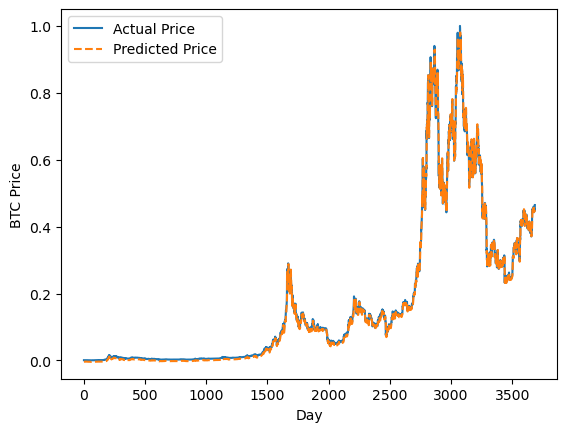

In [798]:
plt.plot(y_train, label="Actual Price")
plt.plot(train_predictions, label="Predicted Price", linestyle="--")
plt.xlabel("Day")
plt.ylabel("BTC Price")
plt.legend()
plt.show()

Because we normalized the BTC prices to values in the interval $[0, 1]$, the actual BTC prices can be obtained by applying the inverse operation used during the normalization process. Let $p_i$ and $p^{\prime}_i$ represent the actual and normalized prices, respectively, at time instant $i$, and $p$ be the set of prices. The conversion from normalized to actual prices is given by the formula:

$$
p_i = p^{\prime}_i \cdot (\max(p) - \min(p)) + \min(p)
$$

This formula scales the normalized prices back to the original scale, allowing us to obtain the real BTC prices. To apply this transformation to the normalized Bitcoin prices from the training and testing arrays, we calculate the maximum and minimum values from the original dataset. Then, we use these values in the following calculations:

In [799]:
max_price = df["bitcoin_price"].max()
min_price = df["bitcoin_price"].min()

real_y_train = y_train * (max_price - min_price) + min_price
real_train_predictions = train_predictions * (max_price - min_price) + min_price
real_y_test = y_test * (max_price - min_price) + min_price
real_test_predictions = test_predictions * (max_price - min_price) + min_price

To gain insights into the performance of our Bitcoin price prediction model, we visualize the actual and predicted prices from the test dataset. The x-axis represents the days, starting from the day following the last day of the training set.

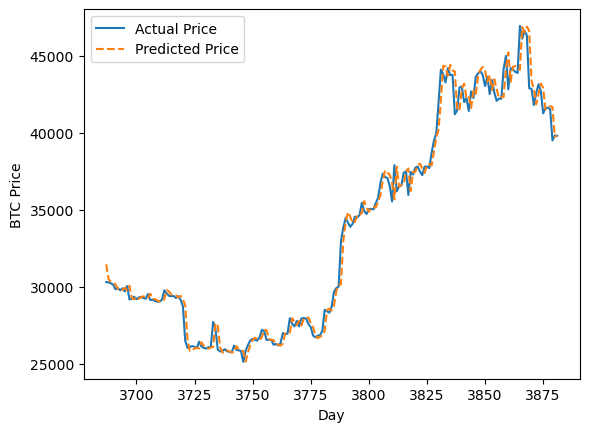

In [800]:
# Determine the x-axis range for the test set
# Start from the day following the last day of the training set
len_train, len_test = len(y_train), len(y_test)
x_range = np.arange(len_train + 1, len_train + len_test + 1)

# Plot actual and predicted prices
plt.plot(x_range, real_y_test, label="Actual Price")
plt.plot(x_range, real_test_predictions, label="Predicted Price", linestyle="--")
plt.xlabel("Day")
plt.ylabel("BTC Price")
plt.legend()
plt.show()

## Bitcoin Price Forecasting

To predict future crypto prices, we introduce the `crypto_forecasting()` function. This function generates a sequence of $n$ predictions for the upcoming days based on an initial input vector at time $t_0$:

In [801]:
def crypto_forecasting(
    model: LSTM, 
    input_tensor: torch.Tensor, 
    days: int
    ):
    predictions = []
    for _ in range(days):
        # Make model prediction
        with torch.no_grad():
            prediction = model(input_tensor.to(device))
        prediction = prediction[0][0]
        predictions.append(prediction.to("cpu").numpy())
        # Update model input
        input_tensor = torch.roll(input_tensor, -1)
        input_tensor[-1] = prediction

    return np.array(predictions)

When making predictions, we have to make sure that the input sequences provided to the model have the same length as the sequences used during training. This ensures that the model processes the input data in a manner consistent with its training phase, allowing it to generate meaningful predictions based on the learned patterns.

We have analyzed the model's performance on the test set using real input vectors at each time step. An interesting scenario to explore is the case where we initiate predictions using only the initial real input vector and then construct subsequent input vectors with predicted outputs.

The `predicted_interval_price_graph()` function is designed to provide insights into the model's predictive performance on unseen data over specified intervals. Given a time range $[t_0​,t_n​]$ and subintervals of the form $[t_i,t_i+ \Delta t]$, the function visualizes the interplay between actual and predicted Bitcoin prices within each subinterval.

For each starting point $t_i$ within the overall range, the function plots the actual Bitcoin prices from $t_i$ to $t_i + \Delta t$​ alongside the model's predicted prices for the same interval. Notably, the model is provided with the real input vector at $t_i$ to initiate predictions. Subsequent predictions for $t_{i+1}, t_{i+2}, \dots, t_{i+\Delta t}$​ are then based on the model's own previous predictions, forming a sequence.

This process repeats for subsequent starting points $t_j = t_i + \Delta t + 1$, where the model again uses the real value at $t_j$ as the input and continues predicting within the corresponding subinterval.

Essentially, the function offers a dynamic view of the model's forecasting behavior, showcasing its ability to rely on its own predictions over sequential subintervals. The resulting visualizations enable users to observe trends, assess the model's adaptability, and gauge its accuracy in capturing price fluctuations over different time spans. The use of subintervals provides a granular understanding of the model's performance, allowing for valuable insights into its predictive capabilities.

In [802]:
def predicted_interval_price_graph(
        model: LSTM, 
        days_interval: list[int], 
        X: np.ndarray, 
        y: np.ndarray,
        max_price: float,
        min_price: float,
        total_ticks: int,
        is_data_normalized: bool = True,
        ax: plt.Axes = None
        ):
    # Make predictions
    interval_length = days_interval[1] - days_interval[0]
    predictions = []
    for day in days_interval[0:len(days_interval)-1]:
        input_tensor = torch.from_numpy(X[day].copy()).float()
        input_tensor = input_tensor.reshape((1, len(input_tensor), 1))
        prediction = crypto_forecasting(model, input_tensor, interval_length)    
        predictions.extend(prediction)
    predictions = np.array(predictions)

    # Setup data
    days = [i for i in range(days_interval[0], days_interval[-1])]
    y = y[days]
    if is_data_normalized:
        predictions = predictions * (max_price - min_price) + min_price
        y = y * (max_price - min_price) + min_price

    # Plot graph
    space_between_ticks = len(days_interval)//total_ticks
    ticks_range = range(0, len(days_interval), space_between_ticks)
    xticks = [days_interval[i] for i in ticks_range]
    if ax is None:
        _, ax = plt.subplots()
    ax.plot(days, y, color="#1f77b4", label="Actual Price")
    ax.plot(days, predictions,
             label="Predicted Price", 
             linestyle="--", color="#ff7f0e", 
            linewidth=2)
    ax.set_title("Model Performance Based On Previous Predictions")
    ax.set_xticks(xticks)
    ax.set_xlabel("Day")
    ax.set_ylabel("BTC Price")
    ax.grid()
    ax.legend()

Let's focus on a specific interval, such as $[3000, 3200]$, and break it down into smaller, equally spaced subintervals with a length of $\Delta t = 10$:

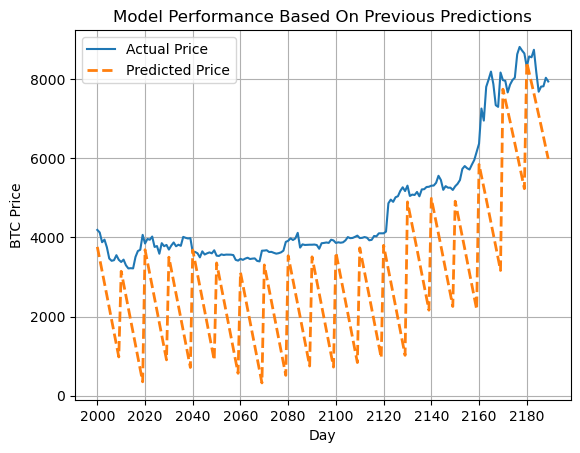

In [803]:
days_interval = list(range(2000, 2200, 10))
predicted_interval_price_graph(model, days_interval, X, y, max_price, min_price, total_ticks=10)

This approach makes the model performance decrease considerably. This is caused by the fact that the predicted output at time $t_{k-1}$ is the input for time  $t_{k}$. Then inaccuracies or errors in the prediction at $t_{k-1}$ will influence the subsequent predictions. Over time, these errors accumulate, and the model's predictions may deviate significantly from the true values.

To mitigate this problem, one potential solution is to increase the window length $w$. By doing so, we reduce the ratio of predicted-known data in the input vector. This adjustment helps minimize the impact of errors from previous predictions, potentially improving the model's overall performance.

As we aim to train the model for various input window lengths, we can create two new functions to streamline the process of model training and performance analysis. These functions encapsulate the steps we previously followed to train the model with an input window length of 11. Additionally, the `ModelData` data class serves as a container to store relevant model data, generated during the training process by the `train_mode()` function. This stored data is later utilized by the `model_performance()` function for detailed analysis and visualization:

In [804]:
from dataclasses import dataclass


@dataclass
class ModelData:
    """Class for keeping track of relevant data to the LSTM model."""
    X: np.ndarray
    y: np.ndarray
    X_train_tensor: torch.Tensor
    y_train_tensor: torch.Tensor
    X_test_tensor: torch.Tensor
    y_test_tensor: torch.Tensor
    loss_df: pd.DataFrame
    

def train_model(
        df: pd.DataFrame, 
        symbol: str, 
        input_window: int,
        num_epochs: int = 100,
        ) -> tuple[LSTM, ModelData]:
    """Trains an LSTM model for predicting the price of a given cryptocurrency."""
    # Define train and test datasets
    data = prepare_dataframe_for_lstm(df, symbol, input_window).to_numpy()
    
    X = np.flip(data[:, 1:], axis=1)
    y = data[:, 0]
    X = X.reshape((*X.shape, 1))
    y = y.reshape((*y.shape, 1))

    split_index = int(len(X) * 0.95)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    X_train_tensor = torch.from_numpy(X_train.copy()).float()
    X_test_tensor = torch.from_numpy(X_test.copy()).float()
    y_train_tensor = torch.from_numpy(y_train.copy()).float()
    y_test_tensor = torch.from_numpy(y_test.copy()).float()

    train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
    test_dataset = TimeSeriesDataset(X_test_tensor, y_test_tensor)

    # Create data loaders
    batch_size = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Train LSTM model
    model = LSTM(input_size=1, hidden_size=4, num_layers=1, device=device)
    learning_rate = 0.001
    loss_function = MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    loss_df = run_model(
        num_epochs, model, 
        train_loader, test_loader, 
        loss_function, optimizer, 
        verbose=False)
    
    # Create model data and return model
    model_data = ModelData(X, y, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, loss_df)

    return model, model_data


def model_performance(
        model: LSTM,
        window_length: int, 
        model_data: ModelData, 
        min_price: float, 
        max_price: float,
        days_interval: list[int],
        total_ticks: int,
        figsize: tuple[int, int] = (16, 16)
        ) -> None:
    """Displays graphs to analyze model performance."""
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f"LSTM Performance Analysis ($w={window_length}$)", fontsize=16)

    # Train loss vs validation loss graph
    model_data.loss_df.plot(
        title="Train Loss vs Validation Loss",
        ax=axes[1][0], ylabel="MSE Loss", logy=True, grid=True)

    # Predict prices on train and test sets
    with torch.no_grad():
        train_predictions = model(model_data.X_train_tensor.to(device)).to("cpu").numpy()
        test_predictions = model(model_data.X_test_tensor.to(device)).to("cpu").numpy()

    y_test = model_data.y_test_tensor.to("cpu").numpy()
    y_train = model_data.y_train_tensor.to("cpu").numpy()

    real_y_train = y_train * (max_price - min_price) + min_price
    real_train_predictions = train_predictions * (max_price - min_price) + min_price
    real_y_test = y_test * (max_price - min_price) + min_price
    real_test_predictions = test_predictions * (max_price - min_price) + min_price

    # Predicted vs real train set graph    
    axes[0][0].plot(real_y_train, label="Actual Price")
    axes[0][0].plot(real_train_predictions, label="Predicted Price", linestyle="--")
    axes[0][0].set_title("Train Set: Predicted vs Real Price")
    axes[0][0].set_xlabel("Day")
    axes[0][0].set_ylabel("BTC Price")
    axes[0][0].legend()
    axes[0][0].grid()

    # Predicted vs real test set graph
    x_range = np.arange(len(y_train) + 1, len(y_train) + len(y_test) + 1)
    axes[0][1].plot(x_range, real_y_test, label="Actual Price")
    axes[0][1].plot(x_range, real_test_predictions, label="Predicted Price", linestyle="--")
    axes[0][1].set_title("Test Set: Predicted vs Real Price")
    axes[0][1].set_xlabel("Day")
    axes[0][1].set_ylabel("BTC Price")
    axes[0][1].legend()
    axes[0][1].grid()

    # Model performance on based on previous predictions
    predicted_interval_price_graph(
        model, days_interval, 
        model_data.X, model_data.y,
        max_price, min_price,
        total_ticks, ax=axes[1][1])
    
    plt.show()

Let's create a model with an input window length of $w=365$ and analyze its performance:

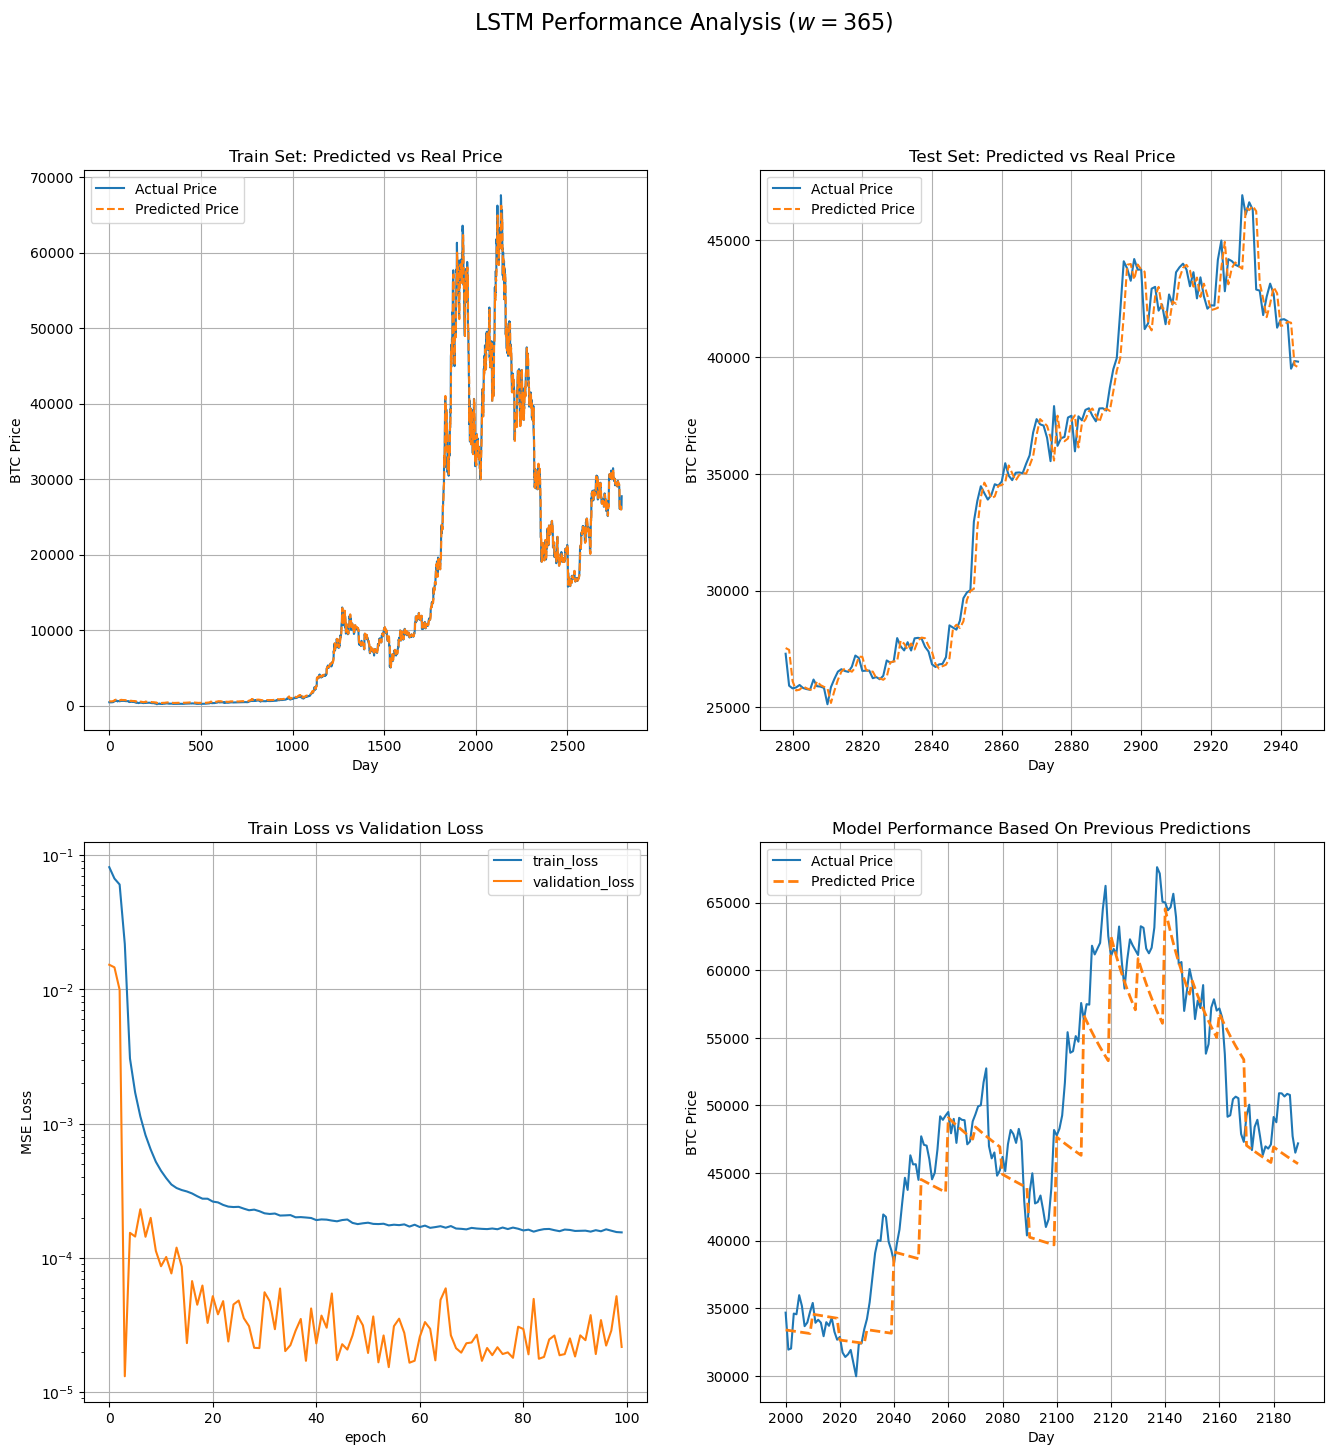

In [805]:
model_w365, model_data = train_model(normalized_df, symbol="bitcoin", input_window=365)
model_performance(
    model=model_w365,
    window_length=365,
    model_data=model_data,
    min_price=df["bitcoin_price"].min(),
    max_price=df["bitcoin_price"].max(),
    days_interval=list(range(2000, 2200, 10)),
    total_ticks=10)

By expanding the window length, we reduce the proportion of predicted data in the input vector, effectively mitigating the impact of errors from previous predictions. 

By comparing the graph *Model Performance Based on Previous Predictions* of the LSTM model with $w=10$ and with $w=365$, we can visualize how the model, given a sufficiently long input window, can overcome the challenge of accumulating errors and produce more accurate and stable forecasts.

# Related Cryptocurrencies Forecasting

In [830]:
from math import ceil


def model_performance_on_related_crypto(
    df: pd.DataFrame, 
    symbol_list: list[str],
    input_window: int, 
    model: LSTM,
    day_range: tuple[int, int] = None,
    graphs_per_row: int = 2,
    figsize: tuple[int, int] = (16, 16),
    ):
    # Axes setup for actual vs predicted price graph
    cols = graphs_per_row
    rows = ceil(len(symbol_list) / cols)
    fig, price_axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle(f"LSTM Performance On Related Cryptos", fontsize=16)
    r, c = 0, 0 # current row and column

    # Evaluation metrics
    MSE = {}
    RMSE = {} 
    MAE = {} 
    MAPE = {} 

    for symbol in symbol_list:
        # Compute X matrix
        crypto_data = prepare_dataframe_for_lstm(df, symbol, input_window).to_numpy()
        
        if day_range:
            crypto_data = crypto_data[day_range[0]:day_range[1]]
        
        crypto_X = np.flip(crypto_data[:, 1:], axis=1)
        crypto_X = crypto_X.reshape((*crypto_X.shape, 1))

        # Compute y vector
        crypto_y = crypto_data[:, 0]
        crypto_y = crypto_y.reshape((*crypto_y.shape, 1))

        # Calculate X tensor
        crypto_max = df[f"{symbol}_price"].max()
        crypto_min = df[f"{symbol}_price"].min()
        crypto_X_tensor = torch.from_numpy(crypto_X.copy()).float()
        crypto_X_tensor = (crypto_X_tensor - crypto_min) / (crypto_max - crypto_min)

        # Predict Prices
        with torch.no_grad():
            crypto_predictions = model(crypto_X_tensor.to(device)).to("cpu").numpy()
        scaled_crypto_predictions = crypto_predictions * (crypto_max - crypto_min) + crypto_min

        # Plot predicted vs real price
        price_axes[r][c].plot(crypto_y, label="Actual Price")
        price_axes[r][c].plot(scaled_crypto_predictions, label="Predicted Price", linestyle="--")
        price_axes[r][c].set_title(f"{symbol.capitalize()} Price Prediction")
        price_axes[r][c].set_xlabel("Day")
        price_axes[r][c].set_ylabel("Price [usd]")
        price_axes[r][c].legend()
        price_axes[r][c].grid()

        # Update current row and column
        if c == cols - 1:
            # Go to next row
            r += 1
            c = 0
        else:
            # Continue on same row
            c += 1
        
    
        # Update evaluation metrics
        normalized_crypto_y = (crypto_y - crypto_min) / (crypto_max - crypto_min)
        n = len(normalized_crypto_y)
        crypto_subtraction = crypto_predictions - normalized_crypto_y

        crypto_MSE = ((1/n) * (crypto_subtraction)**2).cumsum()
        crypto_RMSE = np.sqrt(crypto_MSE)
        crypto_MAE = (1/n) * np.abs(crypto_subtraction).cumsum()
        crypto_MAPE = (1/n) * np.abs(crypto_subtraction/normalized_crypto_y).cumsum()

        MSE[symbol] = crypto_MSE
        RMSE[symbol] = crypto_RMSE
        MAE[symbol] = crypto_MAE
        MAPE[symbol] = crypto_MAPE

    # Display actual vs predicted price graph
    print("[Actual vs Predicted Price Graph]")
    plt.show()

    # Display metrics graphs
    print("[Evaluation Metrics Graph]")
    fig, metrics_axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f"LSTM Evaluation Metrics On Related Cryptos", fontsize=16)
    metrics = {
        "MSE":MSE, "RMSE":RMSE,
        "MAE":MAE, "MAPE":MAPE
        }
    indexes = ((0, 0), (0, 1), (1, 0), (1, 1))

    for idx, metric in zip(indexes, metrics.keys()):
        i, j = idx
       
        for symbol, value in metrics[metric].items():
            metrics_axes[i][j].plot(value, label=f"{symbol.capitalize()} loss")
    
        metrics_axes[i][j].set_xlabel("Day")
        metrics_axes[i][j].set_ylabel(metric)
        metrics_axes[i][j].legend()
        metrics_axes[i][j].grid()
        
    plt.show()

[Actual vs Predicted Price Graph]


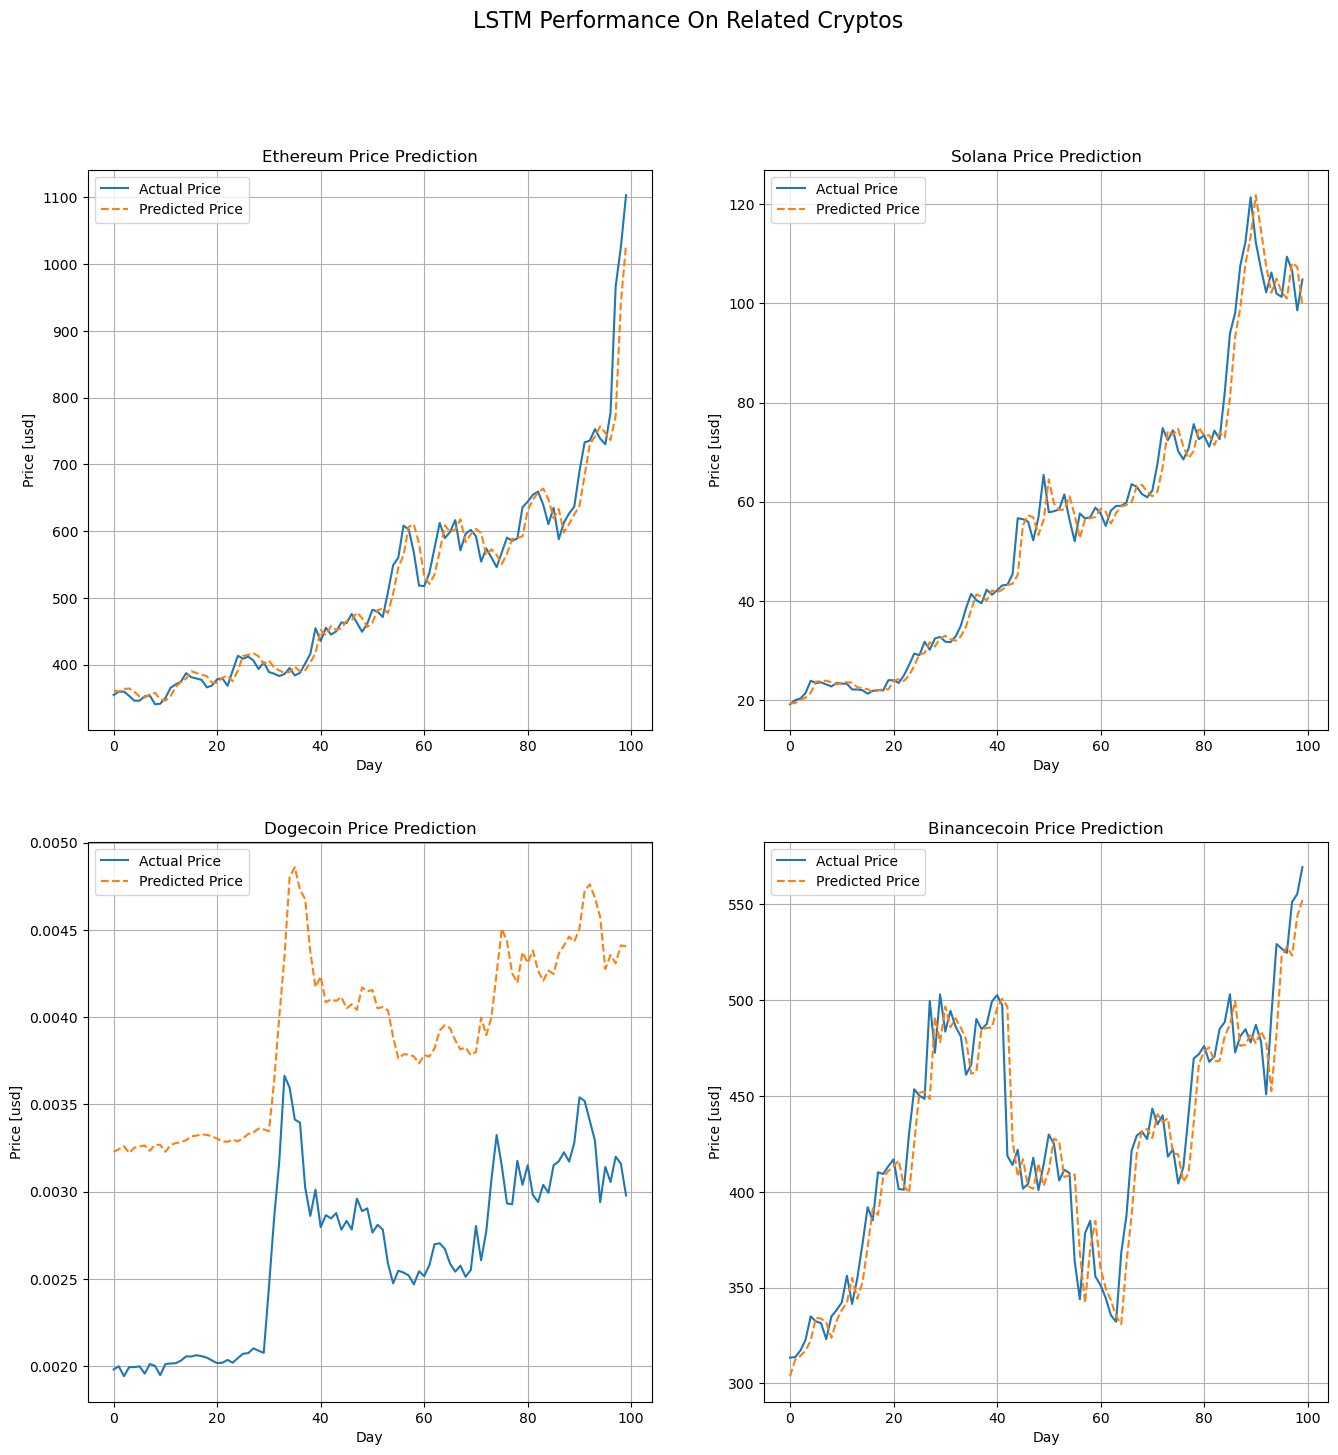

[Evaluation Metrics Graph]


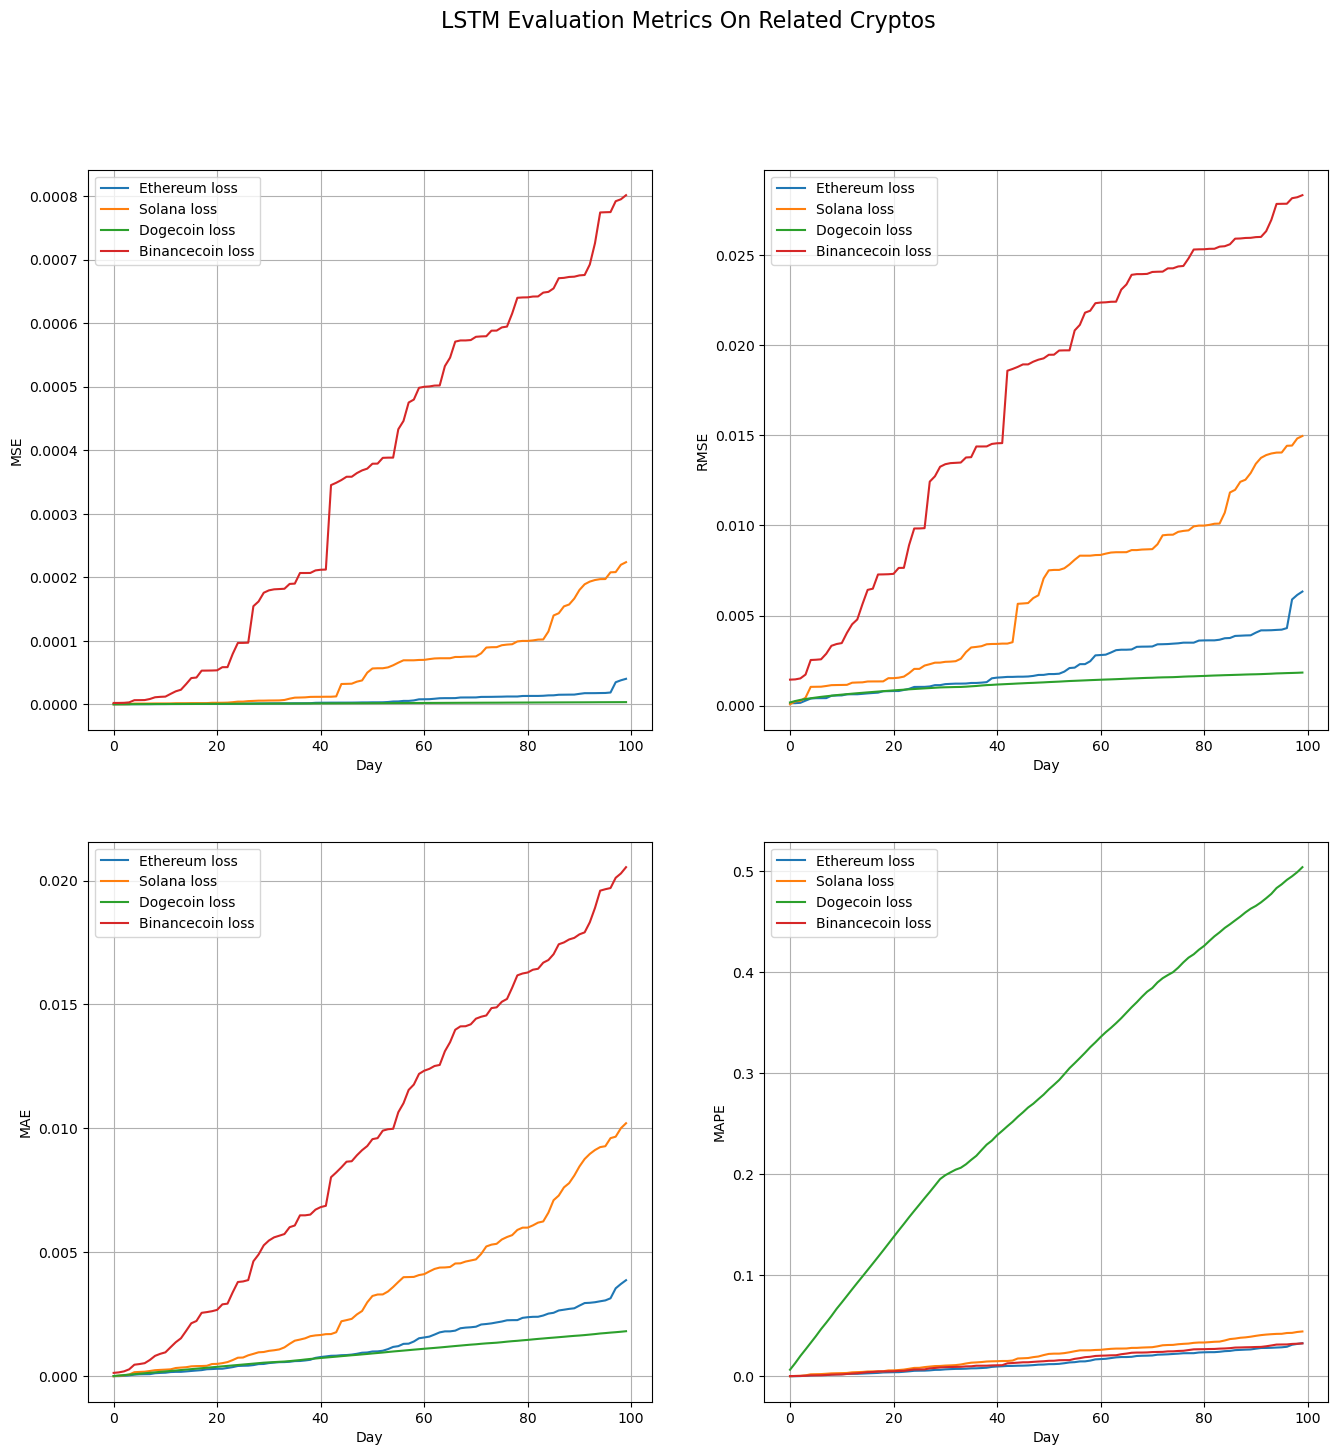

In [831]:
model_performance_on_related_crypto(
    df, 
    symbol_list=["ethereum", "solana", "dogecoin", "binancecoin"], 
    input_window=365, 
    model=model_w365,
    day_range=[900, 1000]
)

# References

[1] Mohil Maheshkumar Patel, Sudeep Tanwar, Rajesh Gupta, Neeraj Kumar (2020). *A Deep Learning-based Cryptocurrency Price Prediction Scheme for Financial Institutions*.

[2] PyTorch Documentation. *torch.nn.LSTM*. PyTorch, version 2.1. Available: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

[3] PyTorch Tutorials. *Datasets & DataLoaders*. PyTorch, version 2.2.0+cu121. Available: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

[4] Yong Yu, Xiaosheng Si, Changhua Hu, Jianxun Zhang. *A Review of Recurrent Neural Networks: LSTM Cells and Network Architectures*.